In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import pearsonr,spearmanr
import scipy.sparse as sparse
from collections import Counter
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [10]:
generated_nets = []
for files in os.listdir("../data/derived/datasets/"):
    generated_nets.append(files)

existing_nets = []
for files in os.listdir("../data/derived/networks/preprocessed/"):
    existing_nets.append(files)

In [12]:
set(generated_nets) - set(existing_nets)

{'airport', 'polblog'}

In [28]:
G = nx.read_edgelist("../data/derived/networks/raw/net_polblogs-rachith.txt")
G.number_of_nodes()

gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gcc = G.subgraph(gcc[0])
Gcc.number_of_nodes()

1222

In [32]:
edge_table = pd.read_csv("../test_data/derived/networks/raw/airport/edge_table.csv")

# =====================
# Construct the network
# =====================
src, trg = edge_table["src"].values, edge_table["trg"].values

G_sada = nx.Graph()
G_sada.add_edges_from(list(zip(src,trg)))
G_sada.number_of_nodes()

2905

In [31]:
G_sada.number_of_nodes()
gcc_sada = sorted(nx.connected_components(G_sada), key=len, reverse=True)
G_sada = G_sada.subgraph(gcc_sada[0])
G_sada.number_of_nodes()

2905

In [2]:
models,skews = [],[]


for file in os.listdir("../data/derived/networks/preprocessed/"):

    edge_table = pd.read_csv(f"../data/derived/networks/preprocessed/{file}/edge_table.csv")

    # =====================
    # Construct the network
    # =====================
    src, trg = edge_table["src"].values, edge_table["trg"].values

    n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
    net = sparse.csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))
    net = net + net.T
    net.data = net.data * 0.0 + 1.0
    deg_seq = net.sum(axis=1).flatten()
    deg_seq = np.asarray(deg_seq)[0]
    deg_count = Counter(deg_seq)
    # deg_dist = {k:round(v/sum(deg_count.values()),3) for k,v in deg_count.items()} 
    deg_dist = {k:v for k,v in deg_count.items()} 


    # skews.append(skew(list(deg_dist.values())))
    skews.append(len(deg_seq))
    models.append(file)

model_skews_df = pd.DataFrame({"data":models,"degree_skews":skews})

In [3]:
input_file = "../data/derived/results/result_auc_roc.csv"
data_table = pd.read_csv(input_file)
data_table.rename(columns={"negativeEdgeSampler": "Sampling"},inplace=True)
data_table["Sampling"] = data_table["Sampling"].map(
    {"uniform": "Uniform", "degreeBiased": "Pref. Attach."}
)

data_table = data_table[data_table.model == "preferentialAttachment"]

#%% ========================
# Style
# ========================
plot_data = data_table.groupby(['data','Sampling'])['score'].mean().reset_index()
plot_data['score_diff'] = plot_data.groupby('data')['score'].diff()

plot_data = plot_data.dropna().reset_index().drop(["Sampling","score","index"],axis=1)
# %%
# ========================
# Plot
# ========================
# sns.set_style("white")
# sns.set(font_scale=1)
# sns.set_style("ticks")

# g = sns.catplot(
#     data=plot_data,
#     x="score",
#     y="model",
#     hue="Sampling",
#     col="data",
#     row="testEdgeFraction",
#     kind="bar",
#     palette=palette,
# )

# g.set_xlabels("AUC-ROC")
# g.set_ylabels("Model")


In [4]:
p = pd.merge(plot_data,model_skews_df,on="data")

Text(0.5, 0, 'number of nodes')

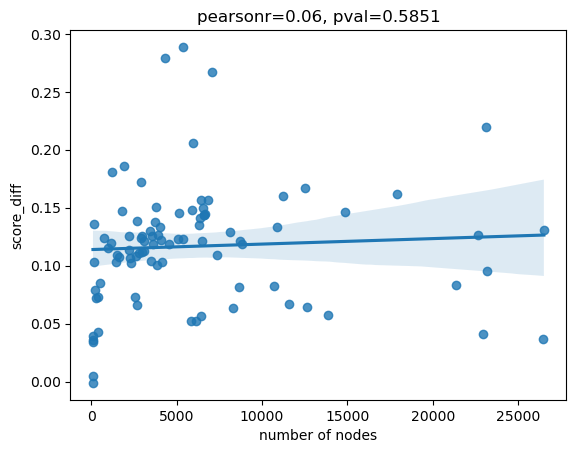

In [11]:
r,pval =  pearsonr(p['degree_skews'], p['score_diff'])
sns.regplot(x="degree_skews", y="score_diff", data=p).set(title=f'pearsonr={round(r,2)}, pval={round(pval,4)}')
# plt.xscale('log')
plt.xlabel("number of nodes")

In [ ]:
r,pval =  spearmanr(p['degree_skews'], p['score_diff'])
sns.regplot(x="degree_skews", y="score_diff", data=p).set(title=f'SpearmanR={round(r,2)}, pval={round(pval,3)}')

<Axes: xlabel='degree_skews', ylabel='score_diff'>

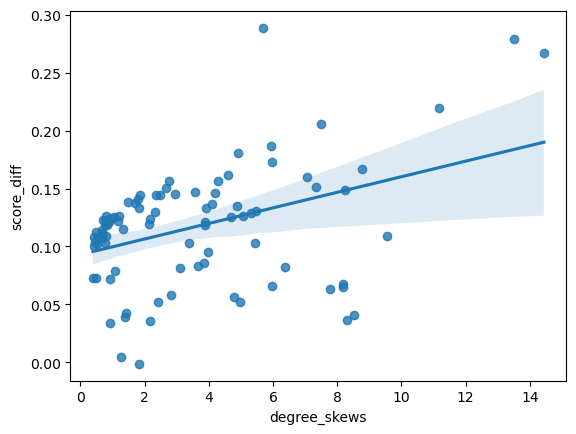

Text(0, 0.5, 'auc_uni - auc_pref')

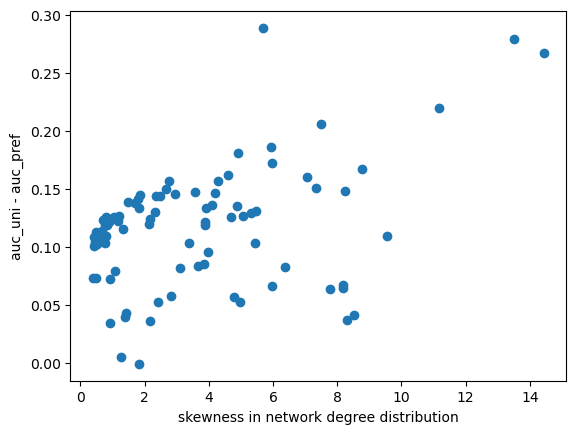

In [165]:
plt.scatter(p.degree_skews.to_list(), p.score_diff.to_list())
plt.xlabel("skewness in network degree distribution")
plt.ylabel("auc_uni - auc_pref")

In [146]:
model_skews_df

,data,degree_skews
0,celegans,0.916927
1,Rice31,1.167392
2,ht09-contact-list,5.673045
3,UChicago30,2.670180
4,p2p-Gnutella06,3.895068
...,...,...
85,Wesleyan43,0.767117
86,lasagne-spanishbook,8.175522
87,Bucknell39,0.415626
88,USFCA72,1.495404


In [151]:
p

,data,score_diff,degree_skews
0,American75,0.023774,1.803726
1,Amherst41,0.023111,0.668669
2,Bowdoin47,0.021634,0.511862
3,Brandeis99,0.024792,1.198748
4,Bucknell39,0.017043,0.415626
...,...,...,...
85,spanishbookinter-st,0.033751,8.182393
86,subelj-cora-cora,0.009258,3.971172
87,subelj-jdk-jdk,0.015958,4.786037
88,subelj-jung-j-jung-j,0.026664,4.955743


In [147]:
plot_data

,data,score_diff
0,American75,0.023774
1,Amherst41,0.023111
2,Bowdoin47,0.021634
3,Brandeis99,0.024792
4,Bucknell39,0.017043
...,...,...
85,spanishbookinter-st,0.033751
86,subelj-cora-cora,0.009258
87,subelj-jdk-jdk,0.015958
88,subelj-jung-j-jung-j,0.026664


In [22]:
net.todense() == net.todense().T

matrix([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])

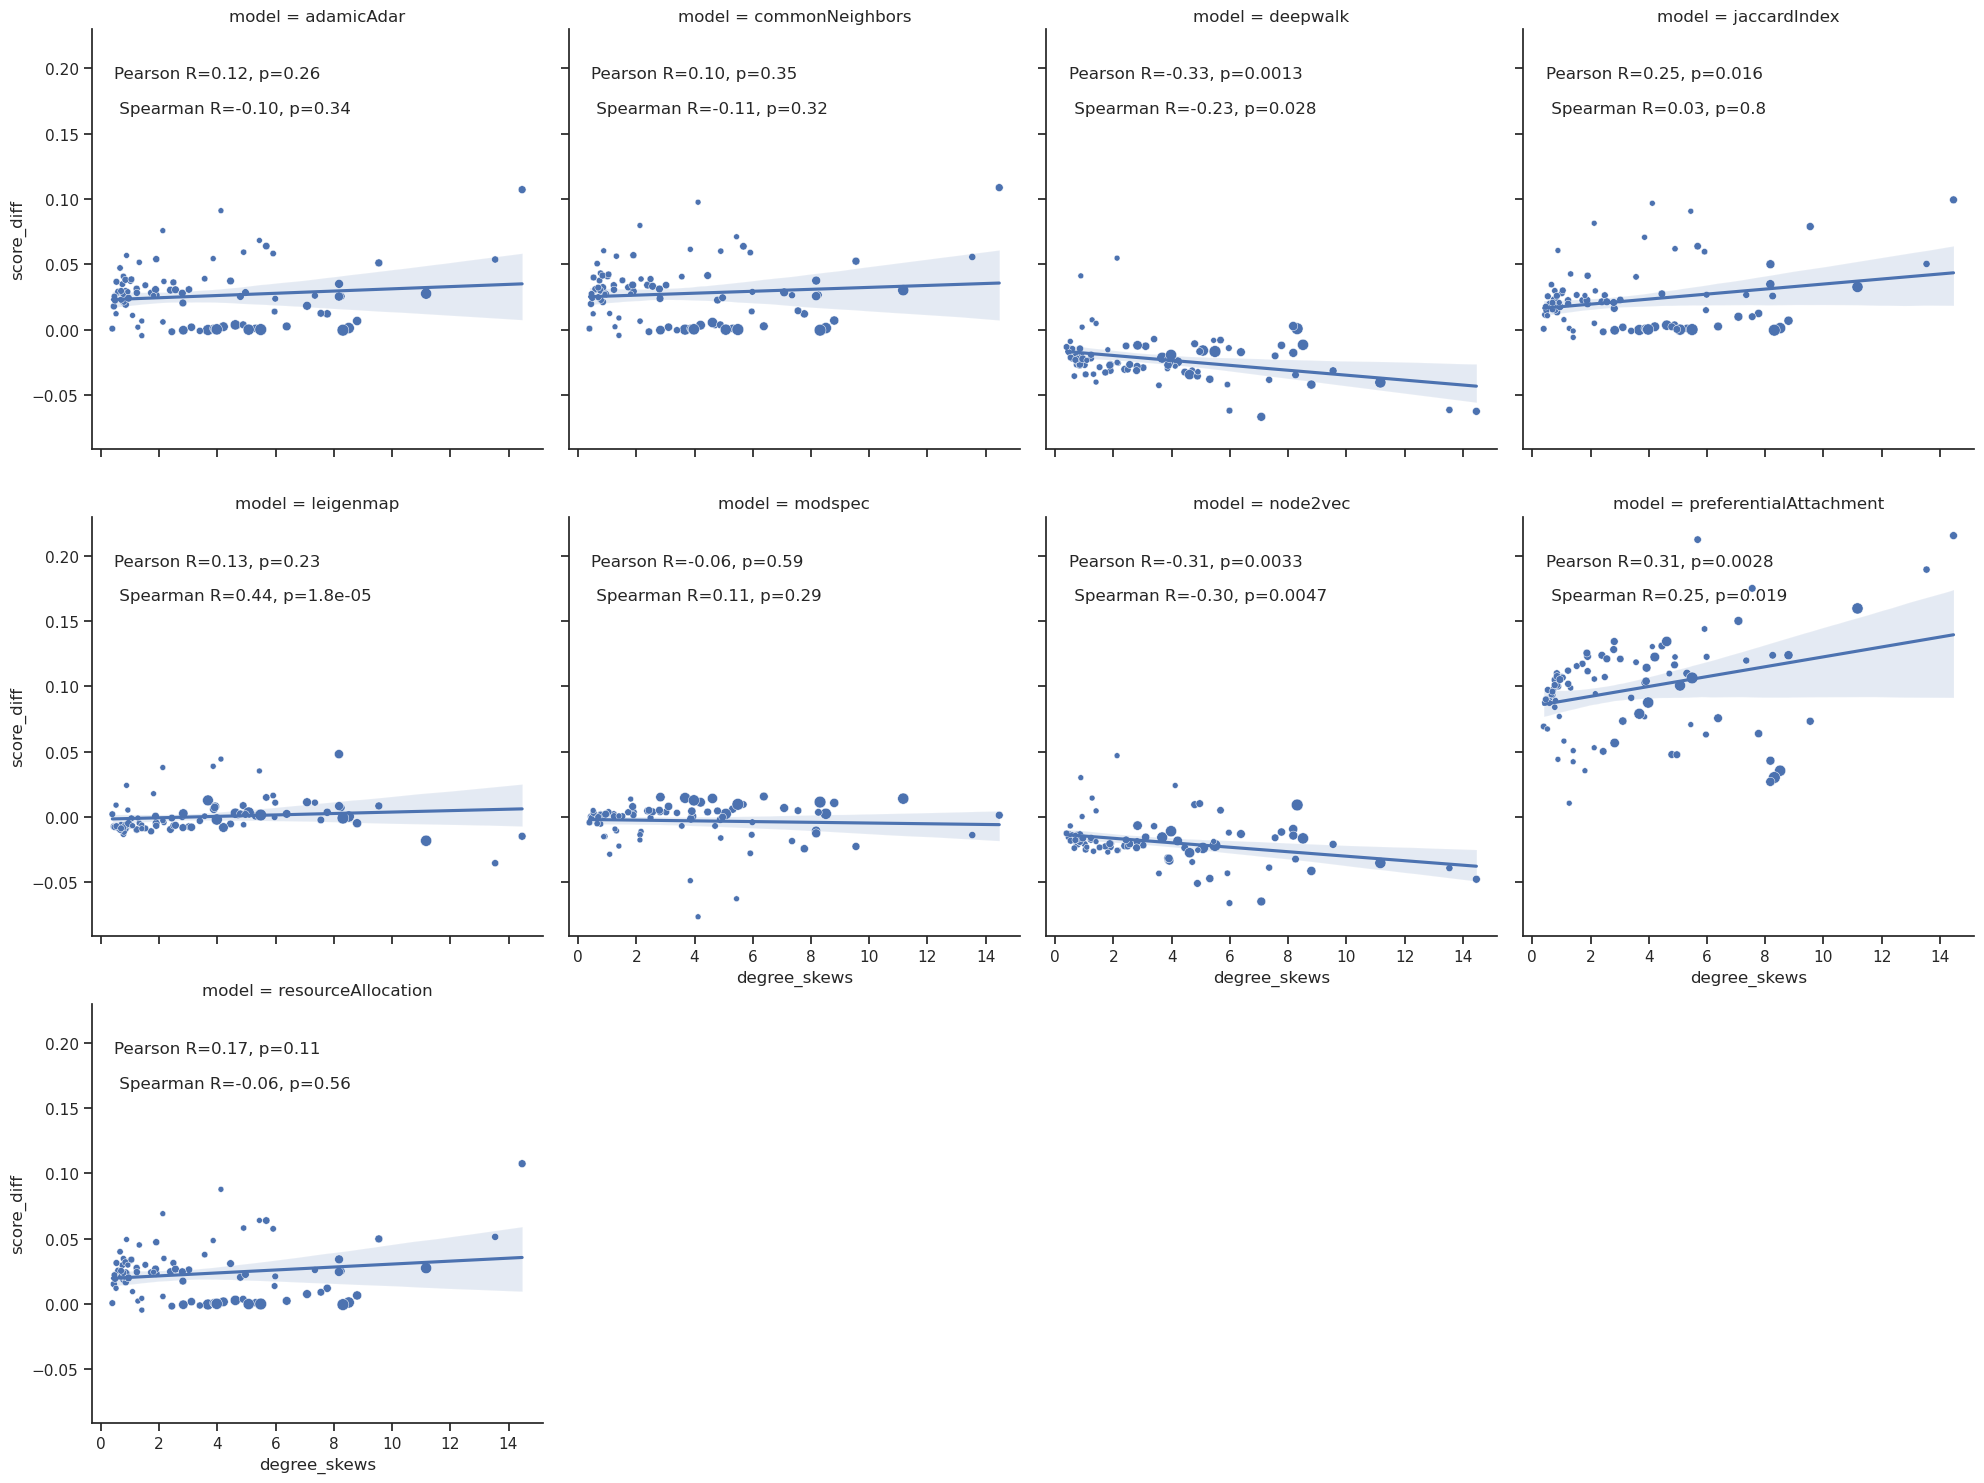

In [2]:
results = "../data/derived/results/result_auc_roc.csv"
networks = "../data/derived/networks/preprocessed/"

# ==========================================
# Get Network properties of all networks 
# (1) skewness of degree distribution skews, 
# (2) and number of nodes 
# ==========================================
network_names ,skews, number_of_nodes = [],[], []
for file in os.listdir(networks):
    edge_table = pd.read_csv(os.path.join(networks,file,"edge_table.csv"))

    # construct network
    src, trg = edge_table["src"].values, edge_table["trg"].values
    n_nodes = int(np.maximum(np.max(src), np.max(trg)) + 1)
    net = sparse.csr_matrix((np.ones_like(src), (src, trg)), shape=(n_nodes, n_nodes))
    
    # ensure unweighed and undirected
    net = net + net.T
    net.data = net.data * 0.0 + 1.0
    
    # get degree distribution
    deg_seq = net.sum(axis=1).flatten()
    deg_seq = np.asarray(deg_seq)[0]
    deg_count = dict(Counter(deg_seq))

    # note, for skew calcuclation,
    # it doesn't matter if these are raw counts or probabilities
    # deg_dist = {k:round(v/sum(deg_count.values()),3) for k,v in deg_count.items()} 
    # deg_dist = {k:v for k,v in deg_count.items()} 

    # get the desired properties
    skews.append(skew(list(deg_count.values())))
    number_of_nodes.append(len(deg_seq))
    network_names.append(file)

network_prop_df = pd.DataFrame({
    "data":network_names,
    "degree_skews":skews,
    "number_of_nodes": number_of_nodes
    })

# ==========================================
# Get the AUC_ROC results
# ==========================================
results_table = pd.read_csv(results)
results_table.rename(columns={"negativeEdgeSampler": "Sampling"},inplace=True)
results_table["Sampling"] = results_table["Sampling"].map(
    {"uniform": "Uniform", "degreeBiased": "Pref. Attach."}
)

results_table = results_table.groupby(['data','Sampling','model'])['score'].mean().reset_index()
results_table['score_diff'] = results_table.groupby(['data','model'])['score'].diff()
results_table = results_table.dropna().reset_index().drop(["Sampling","score","index"],axis=1)


# ==========================================
# Plots
# ==========================================
plot_data = pd.merge(results_table,network_prop_df,on="data")

sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")

def annotate(data, **kwargs):
    "function to write out correlation info on plots"
    rp, pp = pearsonr(data[kwargs['x']], data[kwargs['y']])
    rs, ps = spearmanr(data[kwargs['x']], data[kwargs['y']])
    ax = plt.gca()
    ax.text(.05, .8, 'Pearson R={:.2f}, p={:.2g} \n\n Spearman R={:.2f}, p={:.2g}'.format(rp, pp, rs, ps),
            transform=ax.transAxes)
    

# Degree skew vs auc diff plot
ds_auc = sns.lmplot(
    x="degree_skews", 
    y="score_diff", 
    data=plot_data,
    col = "model",
    col_wrap = 4,
    scatter_kws={'alpha':0},
    )
ds_auc.map_dataframe(annotate, x="degree_skews",y="score_diff")

ds_auc.map(sns.scatterplot, "degree_skews", "score_diff", size=plot_data["number_of_nodes"]*100)

In [4]:
plot_data[plot_data.model == "adamicAdar"]

,data,model,score_diff,degree_skews,number_of_nodes
0,American75,adamicAdar,0.026341,1.897616,6370
9,Amherst41,adamicAdar,0.034816,0.736795,2235
18,Bowdoin47,adamicAdar,0.028271,0.584846,2250
27,Brandeis99,adamicAdar,0.031303,1.225881,3887
36,Bucknell39,adamicAdar,0.017793,0.443414,3824
...,...,...,...,...,...
765,spanishbookinter-st,adamicAdar,0.035004,8.178643,11558
774,subelj-cora-cora,adamicAdar,0.000189,3.979086,23166
783,subelj-jdk-jdk,adamicAdar,0.025349,4.789927,6434
792,subelj-jung-j-jung-j,adamicAdar,0.028433,4.964293,6120


In [5]:
plot_data[plot_data.model == "resourceAllocation"]

,data,model,score_diff,degree_skews,number_of_nodes
8,American75,resourceAllocation,0.023353,1.897616,6370
17,Amherst41,resourceAllocation,0.029716,0.736795,2235
26,Bowdoin47,resourceAllocation,0.025172,0.584846,2250
35,Brandeis99,resourceAllocation,0.027658,1.225881,3887
44,Bucknell39,resourceAllocation,0.015289,0.443414,3824
...,...,...,...,...,...
773,spanishbookinter-st,resourceAllocation,0.034215,8.178643,11558
782,subelj-cora-cora,resourceAllocation,0.000187,3.979086,23166
791,subelj-jdk-jdk,resourceAllocation,0.020491,4.789927,6434
800,subelj-jung-j-jung-j,resourceAllocation,0.022620,4.964293,6120
